# Advanced Lane Line Detection

## Camera Calibration

In [2]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import pickle

nx = 9
ny = 6

def test_image(image_name = './camera_cal/calibration2.jpg'):
    test_image = cv2.imread(image_name)
    test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(test_image, (nx, ny), None)

    cv2.drawChessboardCorners(test_image_gray, (nx,ny), corners, ret)
    plt.imshow(test_image_gray, cmap='gray')
    plt.show()

def get_cal_points(pattern):
    images = glob.glob(pattern)

    # generate an array that has possible point locations e.g. 0,0,0; 0,1,0; 0,2,0
    points = np.float32([[x, y, 0] for y in range(ny) for x in range(nx)])

    obj_points = []
    img_points = []

    print("Processing all files in folder: ", pattern)

    for filename in images:
        image = cv2.imread(filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(image, (nx, ny), None)

        if ret:
            obj_points.append(points)
            img_points.append(corners)
        else:
            print('Chessboard cannot find corneres for:', filename)

    print("Calibration done")
    return obj_points, img_points

def cal_camera(obj_points, img_points, img_size = (1280,720), dump_filename = 'camera_calib.p'):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_size, None, None)
    if ret:
        with open(dump_filename, "wb") as f:
            pickle.dump({'mtx': mtx, 'dist': dist}, f)
            print("mtx and dist arrays have been saved to:", dump_filename)
        
        return mtx, dist
    else:
        print("Could not calibrate camera using the given parameters")
    
def undistort_image(img, mtx, dist, useOptimal = False):
    if useOptimal:
        h,  w = img.shape[:2]
        newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

        dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

        # crop the image
        x,y,w,h = roi
        dst = dst[y:y+h, x:x+w]
        
        return dst
    else:
        return cv2.undistort(img, mtx, dist, None, None)

obj_points, img_points = get_cal_points('./camera_cal/calibration*.jpg')
mtx, dist = cal_camera(obj_points, img_points)


Processing all files in folder:  ./camera_cal/calibration*.jpg
Chessboard cannot find corneres for: ./camera_cal\calibration1.jpg
Chessboard cannot find corneres for: ./camera_cal\calibration4.jpg
Chessboard cannot find corneres for: ./camera_cal\calibration5.jpg
Calibration done
mtx and dist arrays have been saved to: camera_calib.p


## Distortion Test

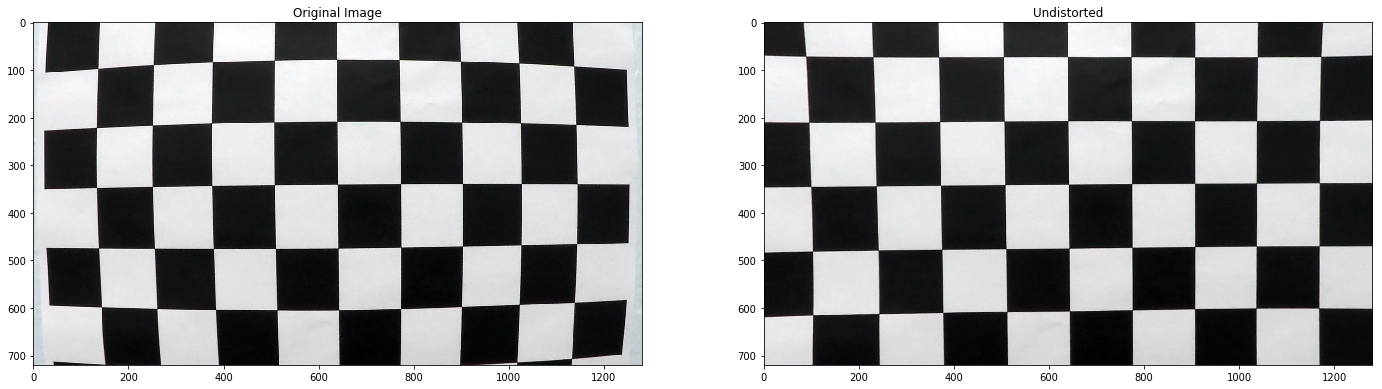

In [3]:
img = cv2.imread('./camera_cal/calibration1.jpg')
dst =  undistort_image(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 9))

ax1.imshow(img)
ax1.set_title('Original Image')
ax2.imshow(dst)
ax2.set_title('Undistorted')

plt.show()

## Edge Detection

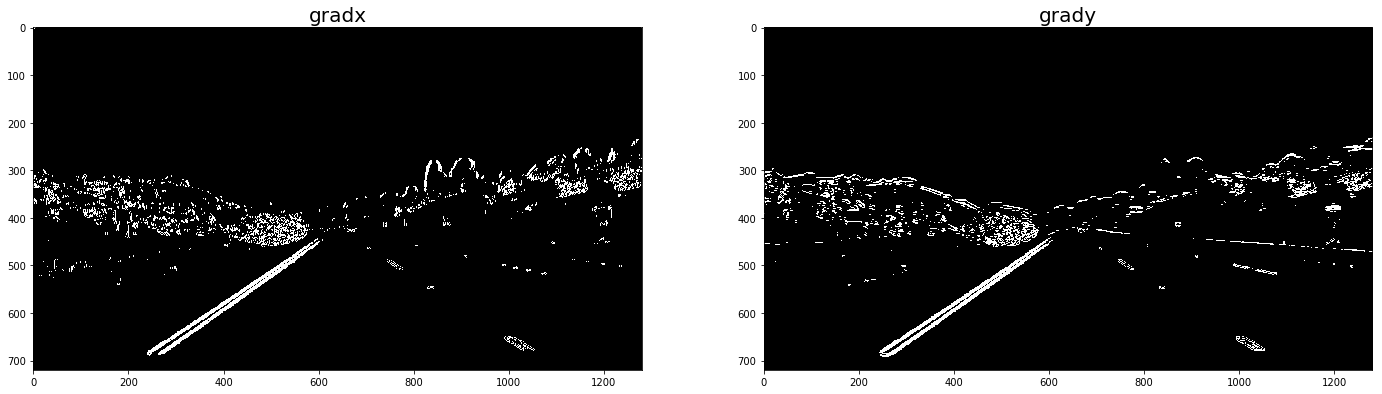

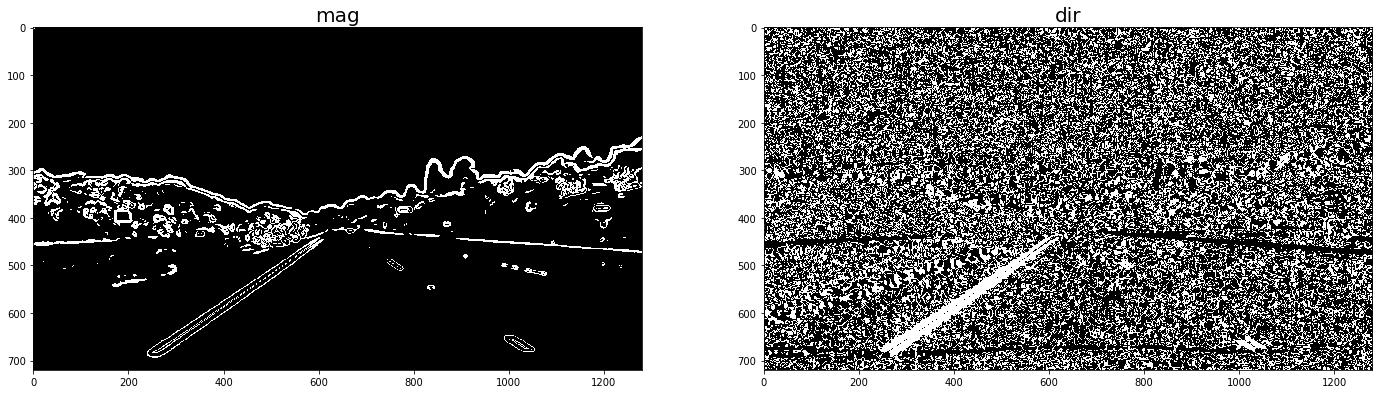

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if len(img.shape) > 2:
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        gray = hls[:,:,2]
    else:
        gray = img
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobel = np.abs(sobel)
    scaled = np.uint8(255.0 * abs_sobel / np.max(abs_sobel))
    
    mask = (scaled >= thresh[0]) & (scaled <= thresh[1])

    grad_binary = np.zeros_like(gray)
    grad_binary[mask] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    if len(img.shape) > 2:
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        gray = hls[:,:,2]
    else:
        gray = img
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    mag = np.sqrt(sobelx ** 2 + sobely ** 2)
    scaled = np.uint8(255.0 * mag / np.max(mag))
    
    mask = (scaled >= mag_thresh[0]) & (scaled <= mag_thresh[1])
    
    mag_binary = np.zeros_like(gray)
    mag_binary[mask] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    if len(img.shape) > 2:
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        gray = hls[:,:,2]
    else:
        gray = img
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    dir_sobel = np.arctan2(np.abs(sobely), np.abs(sobelx))
    
    mask = (dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])

    dir_binary = np.zeros_like(gray)
    dir_binary[mask] = 1
    return dir_binary

image = mpimg.imread('./test_images/straight_lines1.jpg')

ksize = 7
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 90))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(30, 140))
mag_binary = mag_thresh(image, sobel_kernel=21, mag_thresh=(30, 90))
dir_binary = dir_threshold(image, sobel_kernel=19, thresh=(40 * np.pi / 180.0, 73 * np.pi / 180))

# combined = np.zeros_like(dir_binary)
# combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

f, (ax1, ax2) = plt.subplots(1,2, figsize=(24,9))
ax1.imshow(gradx, cmap='gray')
ax1.set_title('gradx', fontsize=20)
ax2.imshow(grady, cmap='gray')
ax2.set_title('grady', fontsize=20)

f, (ax3, ax4) = plt.subplots(1,2, figsize=(24,9))
ax3.imshow(mag_binary, cmap='gray')
ax3.set_title('mag', fontsize=20)
ax4.imshow(dir_binary, cmap='gray')
ax4.set_title('dir', fontsize=20)

# f, (ax1, ax2) = plt.subplots(1,2, figsize=(24,9))
# f.tight_layout()

# ax1.imshow(image)
# ax2.imshow(combined, cmap='gray')
plt.show()


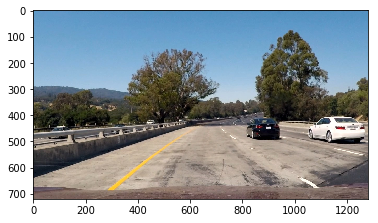

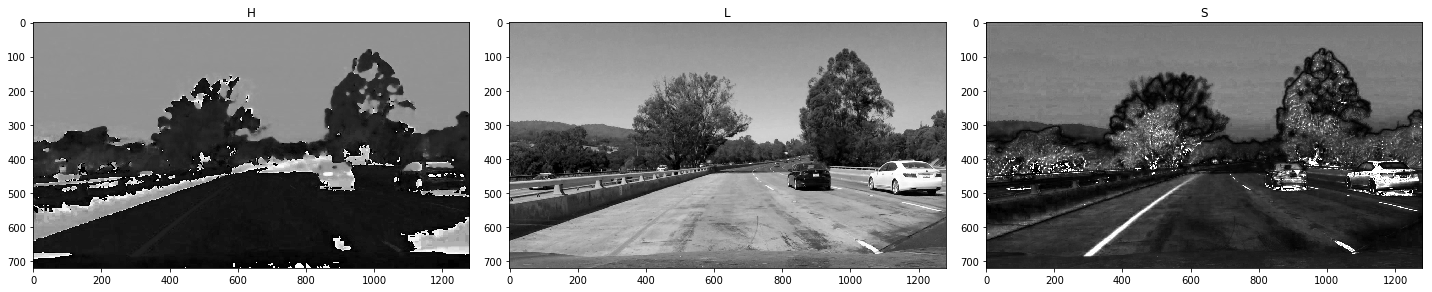

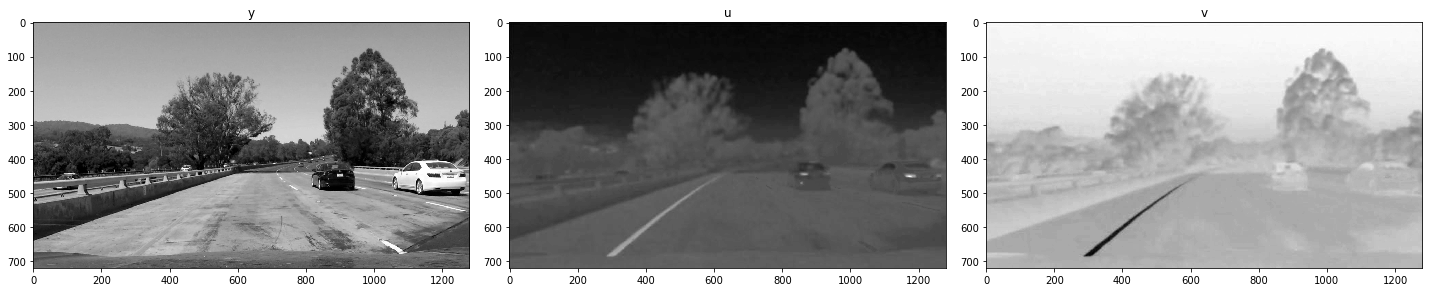

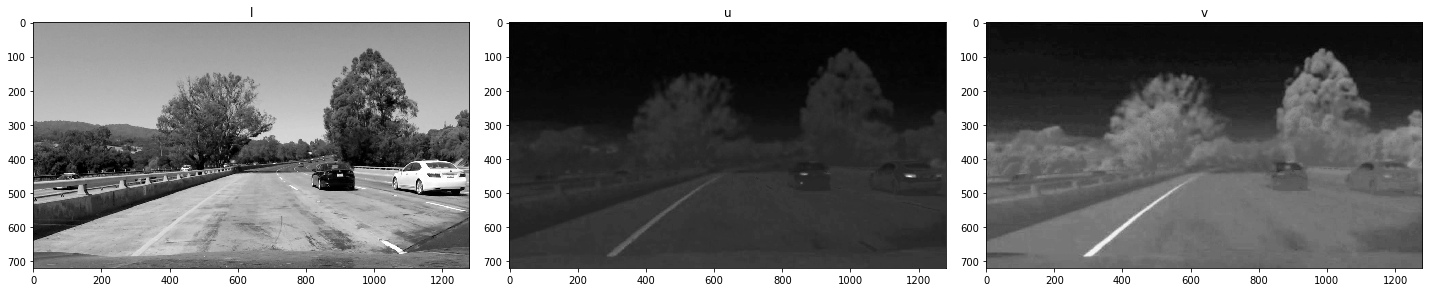

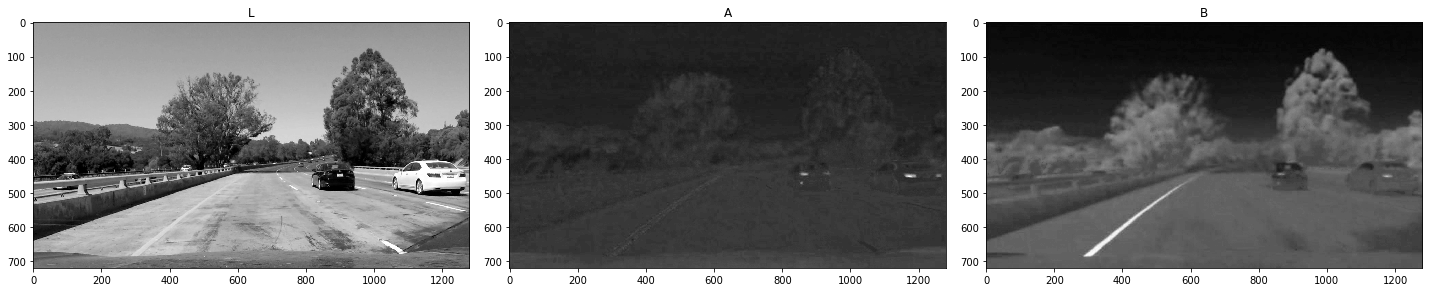

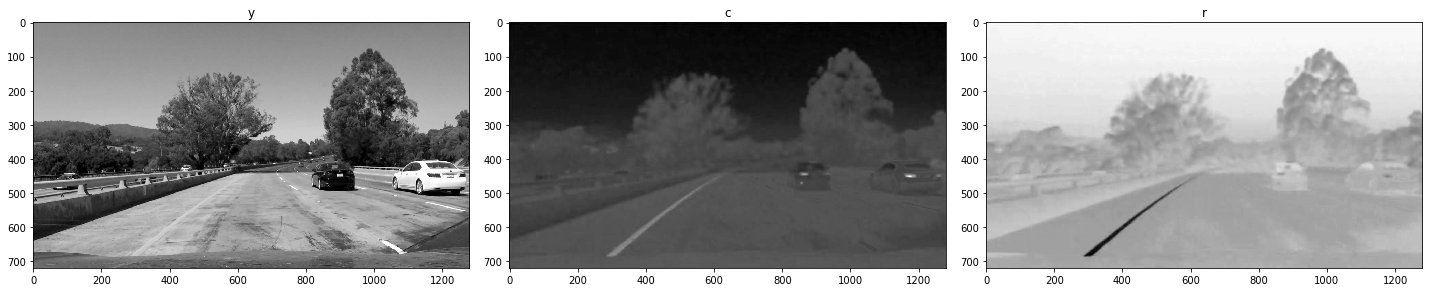

Using HLS


In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#img = mpimg.imread('./test_images/straight_lines1.jpg')
img = mpimg.imread('./test_images/test1.jpg')

def print_channels(title, channels):
    a = channels[:,:,0]
    b = channels[:,:,1]
    c = channels[:,:,2]

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    ax1.imshow(a, cmap='gray')
    ax1.set_title(title[0])
    
    ax2.imshow(b, cmap='gray')
    ax2.set_title(title[1])
    
    ax3.imshow(c, cmap='gray')
    ax3.set_title(title[2])

    f.tight_layout()

def print_using_all():
    conversions = [i for i in dir(cv2) if i.startswith('COLOR_RGB2') and not i.endswith('_FULL')]
    print(conversions)

plt.imshow(img)
plt.show()

hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
print_channels('HLS', hls)

yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV).astype(np.float)
print_channels('yuv', yuv)

luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV).astype(np.float)
print_channels('luv', luv)

lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB).astype(np.float)
print_channels('LAB', lab)

ycbcr = cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB).astype(np.float)
print_channels('ycr', ycbcr)

plt.show()

print('Using HLS')
h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]

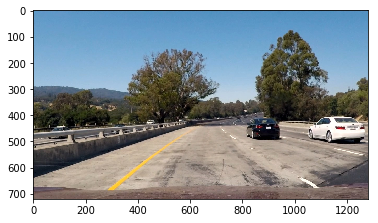

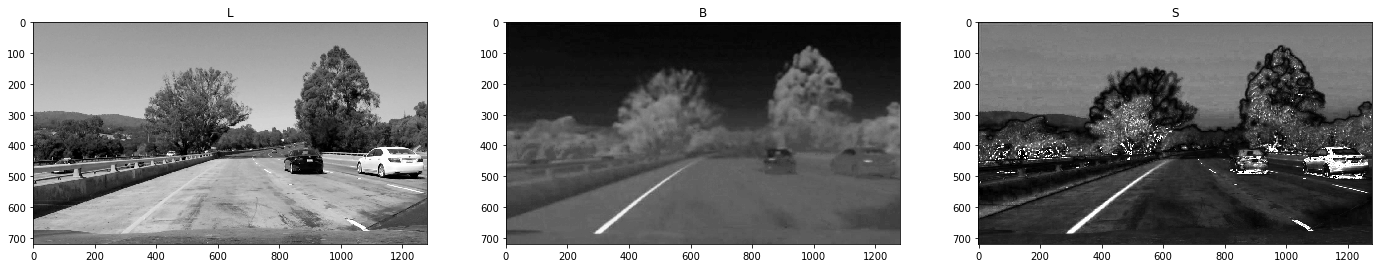

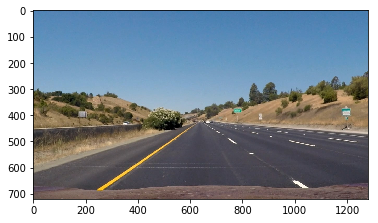

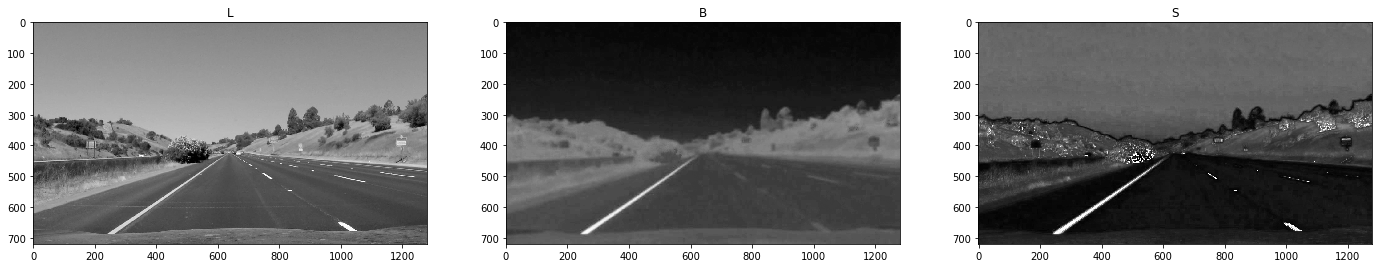

In [6]:
import os

filenames = ['test1.jpg', 'straight_lines1.jpg']

# return L, B, S
def get_lbs_for_thresholding(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    
    return lab[:,:,0], lab[:,:,2], hls[:,:,2]

def show_test_image(filename):
    img = mpimg.imread(os.path.join('./test_images/', filename))

    plt.imshow(img)
    plt.show()

    y, l, s = get_lbs_for_thresholding(img)

    f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(24,9))

    ax1.imshow(y, cmap='gray')
    ax1.set_title('L')
    ax2.imshow(l, cmap='gray')
    ax2.set_title('B')
    ax3.imshow(s, cmap='gray')
    ax3.set_title('S')

    plt.show()
    
show_test_image(filenames[0])
show_test_image(filenames[1])

In [8]:
filenames = ['test1.jpg', 'straight_lines1.jpg']

def get_color_thresh_img(img, color_thresh=(170,255)):
    l,b,s = get_lbs_for_thresholding(img)
    mask = (s >= color_thresh[0]) & (s <= color_thresh[1])
    binary = np.zeros_like(s_channel)
    binary[mask] = 1
    return binary

# def test_color_thresh(filename):
#     img = mpimg.imread(os.path.join('./test_images/', filename))
#     s_thresh = get_color_thresh_img(img)

#     plt.imshow(s_thresh, cmap='gray')
#     plt.suptitle('Color Thresh - ' + filename)
#     plt.show()

# for filename in filenames:
#     test_color_thresh(filename)

## Gradient Thresholding

In [9]:
filenames = [os.path.join('./test_images', filename) for filename in os.listdir('./test_images')]

def get_gradient_img(img):
    l,b,s = get_lbs_for_thresholding(img)
    l[l < 200] = 0

    x = abs_sobel_thresh(l, 'x', sobel_kernel=5, thresh=(40,120))
    mag = mag_thresh(s, sobel_kernel=3, mag_thresh=(40, 150))

    mask = (x == 1) | (mag == 1)
    
    combined = np.zeros_like(l)
    combined[mask] = 1

    return combined

# for f in filenames:
#     img = mpimg.imread(f)
#     combined = get_gradient_img(img)
#     plt.imshow(combined, cmap='gray')
#     plt.show()

## Color + Gradient Threshold

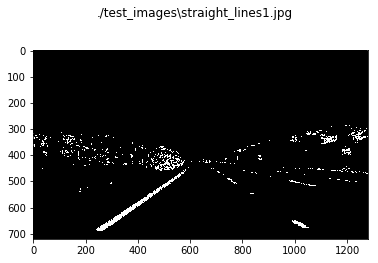

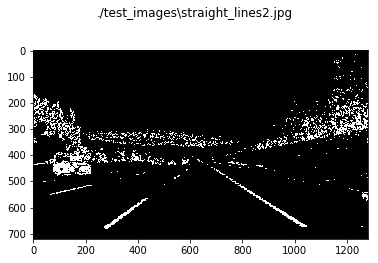

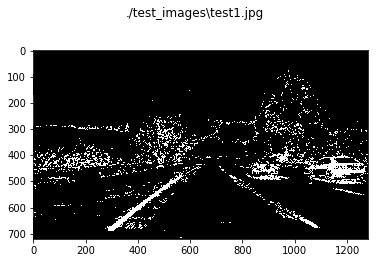

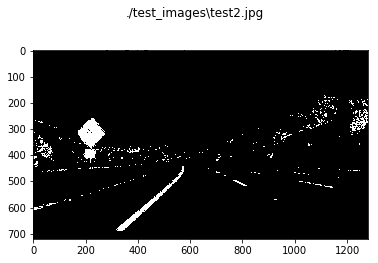

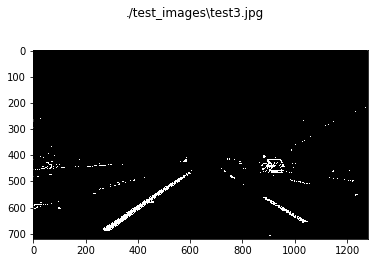

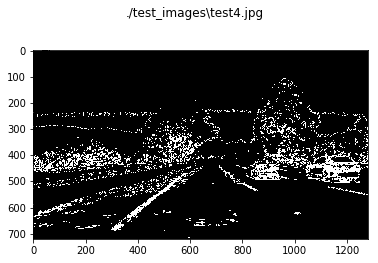

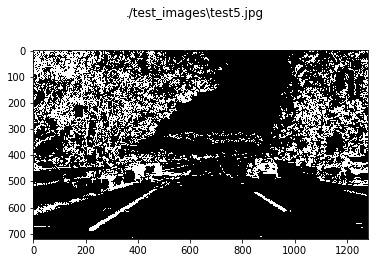

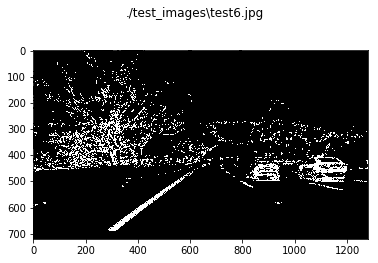

In [18]:
filenames = [os.path.join('./test_images', filename) for filename in os.listdir('./test_images')]

def get_edges(img):
    grad = get_gradient_img(img)
    color_threshold = get_color_thresh_img(img)
    
    combined = np.zeros_like(grad)
    mask = (grad == 1) | (color_threshold == 1)
    combined[mask] = 1
    return combined
    
for filename in filenames:
    img = mpimg.imread(filename)
    img = get_edges(img)
    
    f, ax = plt.subplots(1,1)
    f.suptitle(filename)
    ax.imshow(img, cmap='gray')

    plt.show()


# Pipleline

In [ ]:
filenames = [os.path.join('./test_images', filename) for filename in os.listdir('./test_images')]

def lane_pipiline(img):
    undistort
    